In [1]:
# Dependencies
%matplotlib inline

import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

import seaborn as sns
from math import sqrt

In [2]:
# Read Housing Price Training Data
training_df = pd.read_csv("MLResources/realestate_all_train.csv")
training_df.head()
training_df.count()

County    1188
State     1188
Year      1188
Price     1143
dtype: int64

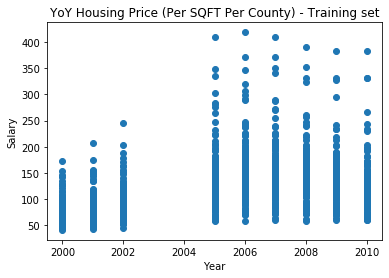

In [3]:
# Plot Training Data - YoY Price of All Counties 
plt.plot(training_df['Year'], training_df['Price'],'o')
plt.title('YoY Housing Price (Per SQFT Per County) - Training set (Unprocessed)')
plt.xlabel('Year')
plt.ylabel('Salary')
plt.show()

In [4]:
# plt.hist(training_df['Price'], 2000)
# plt.show()

In [5]:
# Handle missing data
missing_df = training_df.loc[training_df['Year'].isin(['2003','2004'])]
missing_df.head()  

,County,State,Year,Price


In [7]:
# Backfill missing data for 2003 and 2004 from 2002 and 2005 
backfill_2002_df = training_df.loc[training_df['Year'].isin(['2002'])]
backfill_2005_df = training_df.loc[training_df['Year'].isin(['2005'])]
backfill_2002_df = backfill_2002_df.dropna()
backfill_2005_df = backfill_2005_df.dropna()
backfill_2002_df.count()
backfill_2005_df.count()

County    128
State     128
Year      128
Price     128
dtype: int64

In [8]:
backfill_df = backfill_2002_df.merge(backfill_2005_df, on=['County','State'], how='inner')
backfill_df.head()
# backfill_df.count()

,County,State,Year_x,Price_x,Year_y,Price_y
0,King County,WA,2002,154.750000,2005,202.750000
1,Fairfax County,VA,2002,178.583333,2005,302.750000
2,Montgomery County,MD,2002,170.083333,2005,282.000000
3,Prince Georges County,MD,2002,108.583333,2005,194.166667
4,Baltimore County,MD,2002,99.250000,2005,163.666667


In [9]:
backfill_df['Diff_Price'] = backfill_df['Price_y'] - backfill_df['Price_x']
backfill_df.head()

,County,State,Year_x,Price_x,Year_y,Price_y,Diff_Price
0,King County,WA,2002,154.750000,2005,202.750000,48.000000
1,Fairfax County,VA,2002,178.583333,2005,302.750000,124.166667
2,Montgomery County,MD,2002,170.083333,2005,282.000000,111.916667
3,Prince Georges County,MD,2002,108.583333,2005,194.166667,85.583333
4,Baltimore County,MD,2002,99.250000,2005,163.666667,64.416667


In [10]:
backfill_df['2003_Price'] = backfill_df['Diff_Price']/3 + backfill_df['Price_x']
backfill_df.head()

,County,State,Year_x,Price_x,Year_y,Price_y,Diff_Price,2003_Price
0,King County,WA,2002,154.750000,2005,202.750000,48.000000,170.750000
1,Fairfax County,VA,2002,178.583333,2005,302.750000,124.166667,219.972222
2,Montgomery County,MD,2002,170.083333,2005,282.000000,111.916667,207.388889
3,Prince Georges County,MD,2002,108.583333,2005,194.166667,85.583333,137.111111
4,Baltimore County,MD,2002,99.250000,2005,163.666667,64.416667,120.722222


In [11]:
backfill_df['2004_Price'] = backfill_df['Price_y'] - backfill_df['Diff_Price']/3 
backfill_df.head()

,County,State,Year_x,Price_x,Year_y,Price_y,Diff_Price,2003_Price,2004_Price
0,King County,WA,2002,154.750000,2005,202.750000,48.000000,170.750000,186.750000
1,Fairfax County,VA,2002,178.583333,2005,302.750000,124.166667,219.972222,261.361111
2,Montgomery County,MD,2002,170.083333,2005,282.000000,111.916667,207.388889,244.694444
3,Prince Georges County,MD,2002,108.583333,2005,194.166667,85.583333,137.111111,165.638889
4,Baltimore County,MD,2002,99.250000,2005,163.666667,64.416667,120.722222,142.194444


In [12]:
backfill_2003 = backfill_df.loc[:, ['County','State','Year','2003_Price']]
backfill_2003['Year'] = 2003
backfill_2003 = backfill_2003.rename(columns = {'2003_Price': 'Price'})
backfill_2003.head()

/anaconda3/envs/PythonData/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,County,State,Year,Price
0,King County,WA,2003,170.750000
1,Fairfax County,VA,2003,219.972222
2,Montgomery County,MD,2003,207.388889
3,Prince Georges County,MD,2003,137.111111
4,Baltimore County,MD,2003,120.722222


In [13]:
backfill_2004 = backfill_df.loc[:, ['County','State','Year','2004_Price']]
backfill_2004['Year'] = 2004
backfill_2004 = backfill_2004.rename(columns = {'2004_Price': 'Price'})
backfill_2004.head()

,County,State,Year,Price
0,King County,WA,2004,186.750000
1,Fairfax County,VA,2004,261.361111
2,Montgomery County,MD,2004,244.694444
3,Prince Georges County,MD,2004,165.638889
4,Baltimore County,MD,2004,142.194444


In [14]:
training_df = training_df.append(backfill_2003, ignore_index=True)
training_df = training_df.append(backfill_2004, ignore_index=True)
training_df.head()

,County,State,Year,Price
0,King County,WA,2000,141.166667
1,Fairfax County,VA,2000,134.000000
2,Montgomery County,MD,2000,126.916667
3,Prince Georges County,MD,2000,91.833333
4,Baltimore County,MD,2000,86.750000
5,Pierce County,WA,2000,98.416667
6,Snohomish County,WA,2000,127.500000
7,Baltimore City,MD,2000,52.833333
8,District of Columbia,DC,2000,128.833333
9,Anne Arundel County,MD,2000,106.083333


In [19]:
print(training_df.loc[training_df['Price'].isin(['NaN'])].count())

County    45
State     45
Year      45
Price      0
dtype: int64


In [20]:
training_dfdum = training_df.dropna()
training_dfdum.head()
training_dfdum.count()

County    1391
State     1391
Year      1391
Price     1391
dtype: int64

In [21]:
print(training_dfdum.loc[training_dfdum['Price'].isin(['NaN'])])

Empty DataFrame
Columns: [County, State, Year, Price]
Index: []


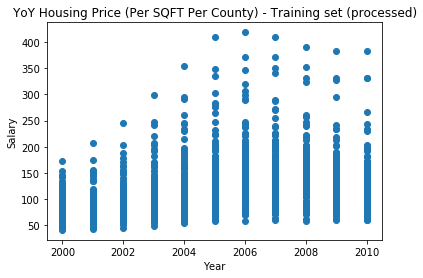

In [22]:
# Plot Training Data After Handling Missig Data - YoY Price of All Counties 
plt.plot(training_df['Year'], training_df['Price'],'o')
plt.title('YoY Housing Price (Per SQFT Per County) - Training set (processed)')
plt.xlabel('Year')
plt.ylabel('Salary')
plt.show()

In [23]:
# Encode Categorical Features - County and State
cat_features = ['County','State']
num_features = ['Price','Year']

categories = cat_features[0:len(cat_features)]

for category in categories:
    series = training_dfdum[category]
    dummies = pd.get_dummies(series, prefix=category)
    training_dfdum = pd.concat([training_dfdum, dummies], axis=1)
    
print(training_dfdum.columns)
training_dfdum.head()

Index(['County', 'State', 'Year', 'Price', 'County_Adams County',
       'County_Allegany County', 'County_Alleghany County',
       'County_Amherst County', 'County_Anne Arundel County',
       'County_Arlington County',
       ...
       'County_Wicomico County', 'County_Williamsburg City',
       'County_Winchester City', 'County_Worcester County',
       'County_Yakima County', 'County_York County', 'State_DC', 'State_MD',
       'State_VA', 'State_WA'],
      dtype='object', length=134)


,County,State,Year,Price,County_Adams County,County_Allegany County,County_Alleghany County,County_Amherst County,County_Anne Arundel County,County_Arlington County,...,County_Wicomico County,County_Williamsburg City,County_Winchester City,County_Worcester County,County_Yakima County,County_York County,State_DC,State_MD,State_VA,State_WA
0,King County,WA,2000,141.166667,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,Fairfax County,VA,2000,134.000000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,Montgomery County,MD,2000,126.916667,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,Prince Georges County,MD,2000,91.833333,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Baltimore County,MD,2000,86.750000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [24]:
# Feature Scaling (remove features not encoded) 
removefeats= ["County","State","Price"]

standardScalerX = StandardScaler()
x = standardScalerX.fit_transform(training_dfdum.drop(removefeats, axis=1))
x

array([[-1.59698669, -0.08928054, -0.08928054, ..., -0.48399403,
        -1.12002547,  1.75135703],
       [-1.59698669, -0.08928054, -0.08928054, ..., -0.48399403,
         0.89283684, -0.5709858 ],
       [-1.59698669, -0.08928054, -0.08928054, ...,  2.06614118,
        -1.12002547, -0.5709858 ],
       ...,
       [-0.33302738, -0.08928054, -0.08928054, ..., -0.48399403,
         0.89283684, -0.5709858 ],
       [-0.33302738, -0.08928054, -0.08928054, ..., -0.48399403,
         0.89283684, -0.5709858 ],
       [-0.33302738, -0.08928054, -0.08928054, ..., -0.48399403,
         0.89283684, -0.5709858 ]])

In [25]:
# Create & Fit Linear Regression Model 
X_train = x
y_train = training_dfdum['Price']

regr = linear_model.LinearRegression()

lr_model = regr.fit(X_train, y_train)


In [26]:
# Predict Training Data
y_train_predict = lr_model.predict(X_train)
print(f"True output: {y_train[0]}")
print(f"Predicted output: {y_train_predict[0]}")
print(f"Prediction Error: {y_train_predict[0]-y_train[0]}")

True output: 141.16666666666666
Predicted output: 156.90212633856203
Prediction Error: 15.73545967189537


In [27]:
print(f"True output: {y_train[2]}")
print(f"Predicted output: {y_train_predict[2]}")
print(f"Prediction Error: {y_train_predict[2]-y_train[2]}")

True output: 126.91666666666669
Predicted output: 149.233000765935
Prediction Error: 22.316334099268317


In [28]:
# R2 Score
score = lr_model.score(X_train, y_train)
print(f"R2 Score: {score}")

R2 Score: 0.8222833410101983


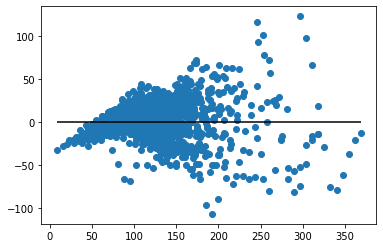

In [29]:
# Plot Residuals
plt.scatter(y_train_predict, y_train_predict - y_train)
plt.hlines(y=0, xmin=y_train_predict.min(), xmax=y_train_predict.max())
plt.show()